In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
from sklearn.preprocessing import RobustScaler   
from sklearn.model_selection import train_test_split
import itertools as it
import xgboost as xgb
from datetime import datetime
import time
from xgboost import XGBClassifier
from sklearn import metrics

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
correct = pd.read_csv("gender_submission.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
pd.isnull(train_data).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
for x in train_data.columns:
    print ("----------%s" % x)
    print (train_data[x].value_counts())

----------PassengerId
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64
----------Survived
0    549
1    342
Name: Survived, dtype: int64
----------Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64
----------Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
----------Sex
male      577
female    314
Name: Sex, dtype: int64
----------Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    2

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data['Embarked']=train_data['Embarked'].fillna('S')

In [8]:
train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0}).astype(int)
train_data['Embarked'] = train_data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

In [9]:
train_data.drop(columns=["Name", "Ticket", "Fare", "Cabin"], inplace=True)

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,1,22.0,1,0,0
1,2,1,1,0,38.0,1,0,1
2,3,1,3,0,26.0,0,0,0
3,4,1,1,0,35.0,1,0,0
4,5,0,3,1,35.0,0,0,0


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int32  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Embarked     891 non-null    int32  
dtypes: float64(1), int32(2), int64(5)
memory usage: 48.9 KB


In [12]:
train_data['Age'].median()

28.0

In [13]:
train_data['Age']=train_data['Age'].fillna(28)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int32  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Embarked     891 non-null    int32  
dtypes: float64(1), int32(2), int64(5)
memory usage: 48.9 KB


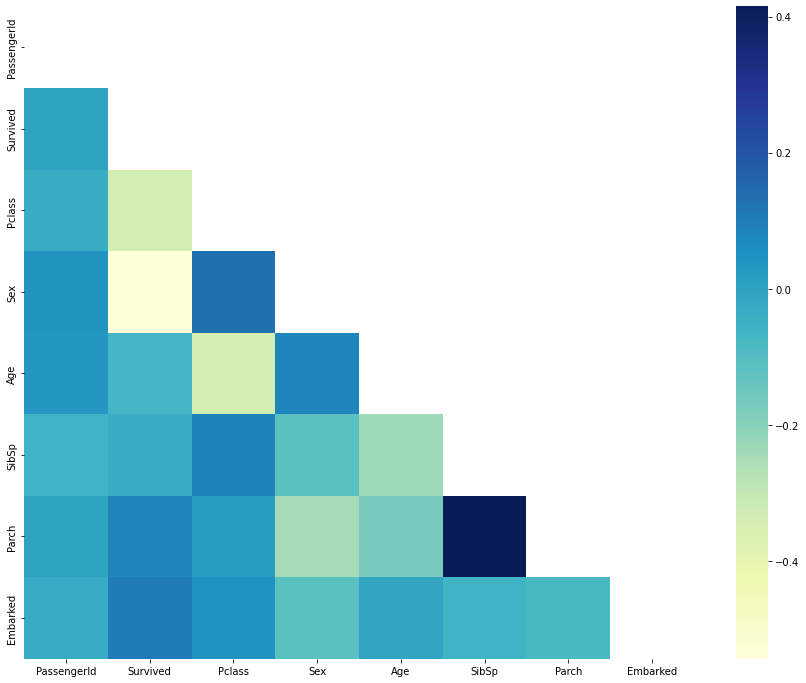

In [15]:
mp.rcParams["figure.figsize"] = [15, 12]

mask = np.triu(np.ones_like(train_data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(train_data.corr(), cmap="YlGnBu", mask=mask)
 
# displaying heatmap
mp.show()

In [16]:
test_data.drop(columns=["Name", "Ticket", "Fare", "Cabin"], inplace=True)

In [17]:
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0}).astype(int)
test_data['Embarked'] = test_data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

In [18]:
test_data[test_data.duplicated()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked


In [19]:
test_data.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [20]:
test_data['Age'].median()

27.0

In [21]:
test_data['Age']=test_data['Age'].fillna(28)

In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int32  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Embarked     418 non-null    int32  
dtypes: float64(1), int32(2), int64(4)
memory usage: 19.7 KB


In [23]:
X_train = train_data.drop(columns=['Survived', 'PassengerId'])
y_train = train_data['Survived']

X_test = test_data.drop(columns=['PassengerId'])

In [24]:
st_x= RobustScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test)

In [25]:
params = {
            "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        }

In [26]:
allNames = params
combinations = it.product(*(params[Name] for Name in allNames))
comb_params = list(combinations)

In [27]:
scores = []
start_time = timer(None) # timing starts from this point for "start_time" variable
for x in comb_params:
    XGB = XGBClassifier(learning_rate=x[0], max_depth=x[1],  min_child_weight=x[2], gamma=x[3], colsample_bytree=x[4])
    XGB.fit(X_train, y_train)
    y_pred_xgb = XGB.predict(X_test)
    scores.append(XGB.score(X_train, y_train))
timer(start_time) 


 Time taken: 0 hours 4 minutes and 4.73 seconds.


In [28]:
len(y_pred_xgb)

418

In [29]:
len(correct['Survived'])

418

In [30]:
max(scores)

0.9712918660287081

In [34]:
best_params = comb_params[scores.index(max(scores))]

In [37]:
best_params

(0.1, 3, 3, 0.4, 0.3)

In [43]:
XGB = XGBClassifier(learning_rate=best_params[0], max_depth=best_params[1],  min_child_weight=best_params[2], gamma=best_params[3], colsample_bytree=best_params[4])
XGB.fit(X_train, y_train)
y_pred_test = XGB.predict(X_test)
XGB.score(X_train, y_train)

0.8181818181818182

In [44]:
Submission = pd.DataFrame({ 'PassengerId': test_data['PassengerId'],
                            'Survived': y_pred_test })
Submission.to_csv("Submission.csv", index=False)